In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os
import numpy as np

In [2]:
import pandas as pd

# Definir la ruta base del dataset
base_path = '/home/canveo/carla_ws/dataset_seg'  # Cambia esto a la ruta real de tu dataset

# Crear una lista para almacenar los DataFrames individuales
dataframes = []

# Iterar sobre cada carpeta en el dataset
for i in range(1, 7):
    folder_name = f"dataset_{i}"
    folder_path = os.path.join(base_path, folder_name)
    csv_path = os.path.join(folder_path, "labels.csv")
    
    if os.path.exists(csv_path):
        # Leer el archivo CSV en un DataFrame
        df = pd.read_csv(csv_path)
        
        # Filtrar las columnas necesarias
        df = df[["image_rgb_name", "image_seg_name", "label"]]
        
        # Agregar la ruta completa a la columna "image_name"
        df["image_rgb_name"] = df["image_rgb_name"].apply(lambda x: f"{folder_name}/imageRGB/{x}")
        df["image_seg_name"] = df["image_seg_name"].apply(lambda x: f"{folder_name}/imageSEG/{x}")
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
final_df = pd.concat(dataframes, ignore_index=True)

# Mostrar los primeros registros del DataFrame final
print(final_df.head())

# Guardar el DataFrame final en un archivo CSV si es necesario
# final_df.to_csv(os.path.join(base_path, "combined_data.csv"), index=False)

                          image_rgb_name  \
0  dataset_1/imageRGB/frame_2038_rgb.png   
1  dataset_1/imageRGB/frame_2086_rgb.png   
2  dataset_1/imageRGB/frame_2160_rgb.png   
3  dataset_1/imageRGB/frame_2193_rgb.png   
4  dataset_1/imageRGB/frame_2236_rgb.png   

                          image_seg_name  label  
0  dataset_1/imageSEG/frame_2038_seg.png  recto  
1  dataset_1/imageSEG/frame_2086_seg.png  recto  
2  dataset_1/imageSEG/frame_2160_seg.png  recto  
3  dataset_1/imageSEG/frame_2193_seg.png  recto  
4  dataset_1/imageSEG/frame_2236_seg.png  recto  


In [3]:
class_counts = final_df['label'].value_counts()
print("Distribución de clases antes del balanceo:")
print(class_counts)

Distribución de clases antes del balanceo:
label
recto    48223
curvo    18978
Name: count, dtype: int64


In [4]:
minority_class_count = class_counts.min()

# Crear un DataFrame balanceado tomando muestras aleatorias
balanced_df = pd.concat([
    final_df[final_df['label'] == label].sample(minority_class_count, random_state=42)
    for label in class_counts.index
], ignore_index=True)

# Mostrar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(balanced_df['label'].value_counts())

# Guardar el DataFrame balanceado en un archivo CSV si es necesario
balanced_df.to_csv(os.path.join(base_path, "combined_data_balanced.csv"), index=False)

# Mostrar los primeros registros del DataFrame balanceado
print(balanced_df.head())

Distribución de clases después del balanceo:
label
recto    18978
curvo    18978
Name: count, dtype: int64
                            image_rgb_name  \
0  dataset_1/imageRGB/frame_478336_rgb.png   
1  dataset_2/imageRGB/frame_488708_rgb.png   
2  dataset_6/imageRGB/frame_464772_rgb.png   
3  dataset_4/imageRGB/frame_559602_rgb.png   
4  dataset_5/imageRGB/frame_288530_rgb.png   

                            image_seg_name  label  
0  dataset_1/imageSEG/frame_478336_seg.png  recto  
1  dataset_2/imageSEG/frame_488708_seg.png  recto  
2  dataset_6/imageSEG/frame_464772_seg.png  recto  
3  dataset_4/imageSEG/frame_559602_seg.png  recto  
4  dataset_5/imageSEG/frame_288530_seg.png  recto  


In [5]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transformaciones de imagen (ajustadas para EfficientNet) usando Albumentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    A.GaussianBlur(p=0.2),
    A.MotionBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Dataset personalizado para cargar imágenes y etiquetas
class CurvatureDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_rgb_name = self.dataframe.iloc[idx]['image_rgb_name']
        label = self.dataframe.iloc[idx]['label']

        # Convertir la etiqueta a valor numérico (0 para recto, 1 para curvo)
        label = 0 if label == 'recto' else 1

        # Cargar la imagen RGB
        image_rgb_path = os.path.join(self.base_dir, image_rgb_name)
        image_rgb = Image.open(image_rgb_path).convert("RGB")
        image_rgb = np.array(image_rgb)

        # Aplicar las transformaciones si es necesario
        if self.transform:
            transformed = self.transform(image=image_rgb)
            image_rgb = transformed["image"]

        return image_rgb, torch.tensor(label).long()

# Cargar el DataFrame (balanced_df debe contener las etiquetas)
balanced_df = pd.read_csv('/home/canveo/carla_ws/dataset_seg/combined_data_balanced.csv')

# Dividir en entrenamiento y validación
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Crear datasets de entrenamiento y validación
train_dataset = CurvatureDataset(dataframe=train_df, base_dir='/home/canveo/carla_ws/dataset_seg', transform=train_transform)
val_dataset = CurvatureDataset(dataframe=val_df, base_dir='/home/canveo/carla_ws/dataset_seg', transform=val_transform)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


/home/canveo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations
/home/canveo/venv/lib/python3.10/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [6]:
# import timm

# # Crear el modelo EfficientNet preentrenado
# model = timm.create_model('efficientnet_b0', pretrained=True)  # Puedes cambiar a otros modelos EfficientNet
# num_ftrs = model.get_classifier().in_features  # Obtener el número de características de la última capa

# for param in model.parameters():
#     param.requires_grad = False  # Congelar todas las capas

# # Solo descongelar la última capa
# for param in model.classifier.parameters():
#     param.requires_grad = True


# # Reemplazar la capa de clasificación para adaptarla a nuestra tarea (2 clases: recto y curvo)
# model.classifier = nn.Linear(num_ftrs, 2)  # 2 clases: recto (0) y curvo (1)

# # Mover el modelo al dispositivo (GPU si está disponible)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Definir la función de pérdida y el optimizador
# criterion = nn.CrossEntropyLoss()  # Para clasificación binaria
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Ajusta el learning rate si es necesario
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import timm
# from torch.utils.tensorboard import SummaryWriter

# # Inicializar el modelo EfficientNet_B0
# class EfficientNetWithDropout(nn.Module):
#     def __init__(self, dropout_rate=0.3):
#         super(EfficientNetWithDropout, self).__init__()
#         self.base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
#         self.dropout = nn.Dropout(p=dropout_rate)  # Dropout con tasa 30%
    
#     def forward(self, x):
#         x = self.base_model.forward_features(x)
#         x = self.dropout(x)
#         x = self.base_model.classifier(x)  # Forward hacia la capa de clasificación
#         return x

# # Crear una instancia del modelo con Dropout
# model = EfficientNetWithDropout(dropout_rate=0.3)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Definir la función de pérdida y el optimizador
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)



2024-10-04 18:15:14.586268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 18:15:14.722227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 18:15:14.772611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 18:15:14.787535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 18:15:14.894065: I tensorflow/core/platform/cpu_feature_guar

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.tensorboard import SummaryWriter

# Inicializar el modelo EfficientNet_B0 con Dropout
class EfficientNetWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(EfficientNetWithDropout, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout con tasa 30%
        self.pooling = nn.AdaptiveAvgPool2d(1)  # Pooling para reducir las dimensiones espaciales
    
    def forward(self, x):
        x = self.base_model.forward_features(x)  # Extraer características
        x = self.pooling(x)  # Pooling para reducir dimensiones a (batch_size, num_features, 1, 1)
        x = torch.flatten(x, 1)  # Aplanar las características a (batch_size, num_features)
        x = self.dropout(x)  # Aplicar Dropout
        x = self.base_model.classifier(x)  # Pasar por la capa de clasificación
        return x

# Crear una instancia del modelo con Dropout
model = EfficientNetWithDropout(dropout_rate=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Inicializar TensorBoard
writer = SummaryWriter('runs/efficientnet_b0_with_dropout')  # Puedes especificar el directorio de logs

# Variables para almacenar métricas de entrenamiento
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variable para almacenar la mejor precisión de validación
best_val_accuracy = 0.0

# Parámetros de Early Stopping
patience = 10  # Número de épocas sin mejora antes de detener
counter = 0   # Contador para Early Stopping

# Entrenamiento del modelo
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Registrar métricas de entrenamiento en TensorBoard
    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Training Accuracy', train_accuracy, epoch)
    
    # Validación del modelo
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Registrar métricas de validación en TensorBoard
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

    # Guardar el mejor modelo si la precisión de validación mejora
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_efficientnet_model_with_dropout.pth')
        print(f'Modelo guardado con una mejor precisión de validación: {best_val_accuracy:.2f}%')
        counter = 0  # Reiniciar el contador de paciencia cuando haya mejora
    else:
        counter += 1
        print(f'No hubo mejora en la precisión de validación. Patience: {counter}/{patience}')
        
        # Comprobar si debe detenerse el entrenamiento
        if counter >= patience:
            print(f'Early stopping activado en la época {epoch+1}')
            break

# Cerrar el escritor de TensorBoard
writer.close()


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Epoch 1/40, Train Loss: 1.0708, Val Loss: 0.2899, Train Accuracy: 73.64%, Val Accuracy: 90.21%
Modelo guardado con una mejor precisión de validación: 90.21%
Epoch 2/40, Train Loss: 0.4281, Val Loss: 0.1794, Train Accuracy: 84.99%, Val Accuracy: 93.74%
Modelo guardado con una mejor precisión de validación: 93.74%
Epoch 3/40, Train Loss: 0.2977, Val Loss: 0.1313, Train Accuracy: 89.25%, Val Accuracy: 95.28%
Modelo guardado con una mejor precisión de validación: 95.28%
Epoch 4/40, Train Loss: 0.2290, Val Loss: 0.0960, Train Accuracy: 91.59%, Val Accuracy: 96.51%
Modelo guardado con una mejor precisión de validación: 96.51%
Epoch 5/40, Train Loss: 0.1783, Val Loss: 0.0740, Train Accuracy: 93.47%, Val Accuracy: 97.42%
Modelo guardado con una mejor precisión de validación: 97.42%
Epoch 6/40, Train Loss: 0.1517, Val Loss: 0.0701, Train Accuracy: 94.44%, Val Accuracy: 97.46%
Modelo guardado con una mejor precisión de validación: 97.46%
Epoch 7/40, Train Loss: 0.1302, Val Loss: 0.0774, Train Ac

In [8]:
torch.save(model.state_dict(), 'efficientnet_model.pth')

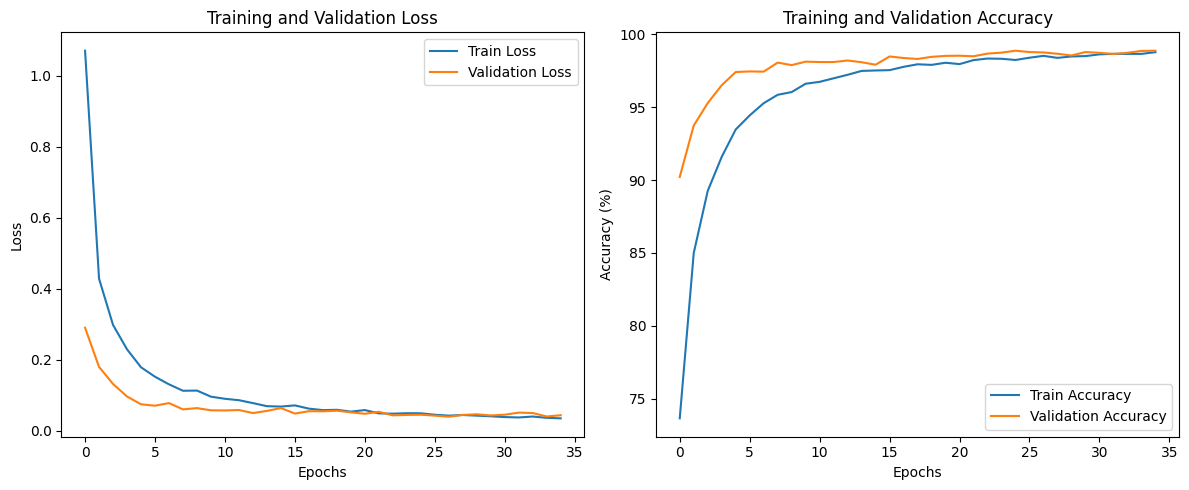

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

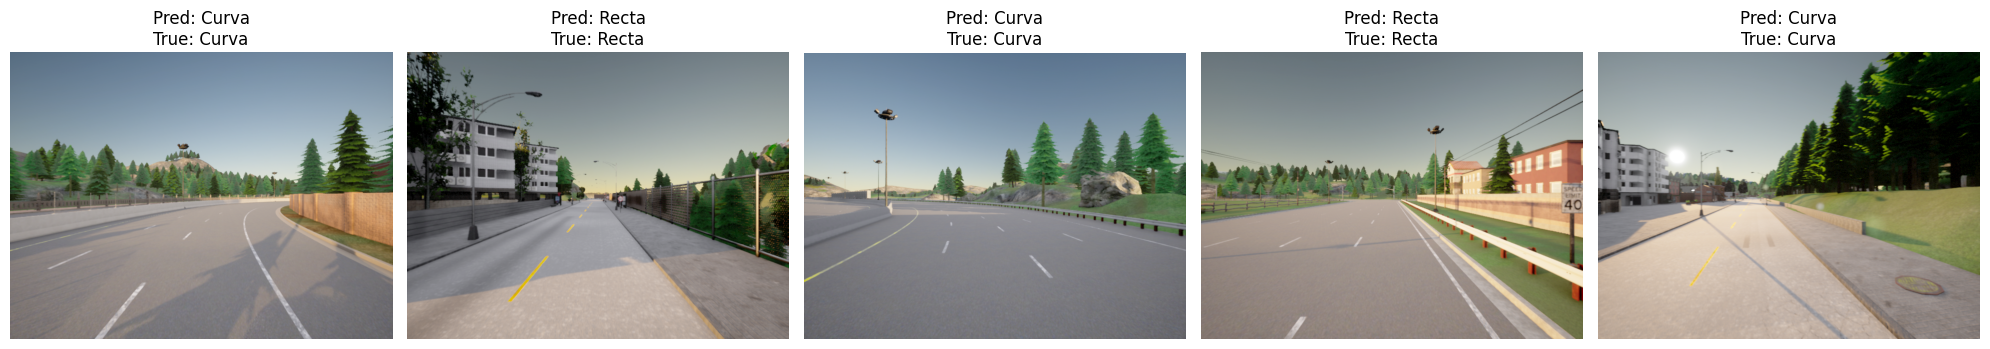

In [11]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Asegúrate de que tu modelo esté en modo de evaluación y en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Transformaciones de preprocesamiento (coinciden con las usadas durante el entrenamiento)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Seleccionar aleatoriamente algunas imágenes del conjunto de validación
num_images_to_test = 5
random_indices = random.sample(range(len(val_df)), k=num_images_to_test)

# Realizar inferencia y mostrar los resultados
fig, axes = plt.subplots(1, num_images_to_test, figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # Obtener el nombre de la imagen y la etiqueta
    img_path = os.path.join('/home/canveo/carla_ws/dataset_seg', val_df.iloc[idx]['image_rgb_name'])
    true_label = val_df.iloc[idx]['label']

    # Cargar la imagen
    img = Image.open(img_path).convert('RGB')

    # Preprocesar la imagen
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Inferencia
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)

    # Decodificar la predicción
    predicted_label = 'Recta' if predicted_class.item() == 0 else 'Curva'
    true_label_str = 'Recta' if true_label == 'recto' else 'Curva'

    # Mostrar la imagen junto con las etiquetas de predicción y reales
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Pred: {predicted_label}\nTrue: {true_label_str}', fontsize=12)

plt.tight_layout()
plt.show()
